In [1]:
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import os
import cv2
import seaborn as sns
import torch
import torch.nn.functional as F
import math

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
path_train_high = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\train\high_res'
path_train_low = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\train\low_res'
path_val_high = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\val\high_res'
path_val_low = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\val\low_res'

In [4]:
#### Funcion para leer imagenes dentro de una carpeta
width = 256
height = 256
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)
        if (len(originalImage.shape)==3):
            originalImage = imread(path1)[:,:,2]
        #print(originalImage.shape)
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images

C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


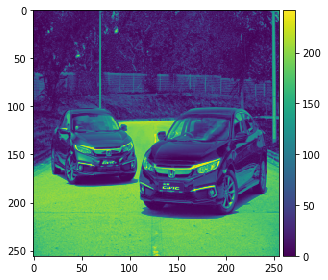

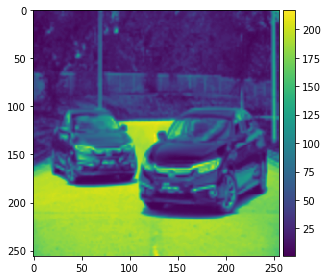

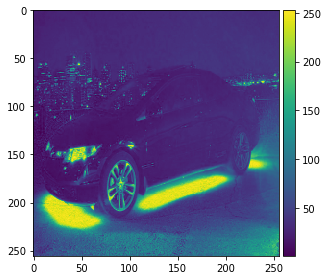

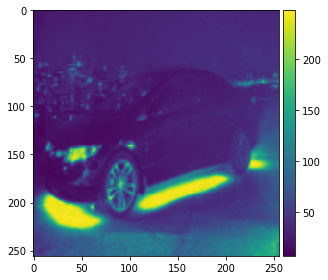

In [5]:
train_high = imageReading (path_train_high)
train_low = imageReading (path_train_low)
val_high = imageReading (path_val_high)
val_low = imageReading (path_val_low)

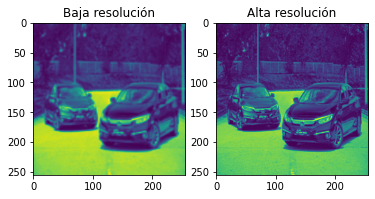

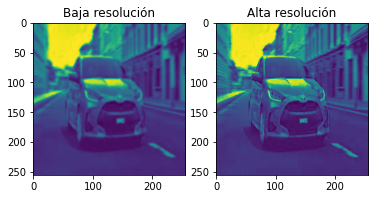

In [6]:
plt.figure(1)
plt.subplot(122)
plt.imshow(np.reshape(train_high[0],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(train_low[0],(256,256))), plt.title('Baja resolución')
plt.show()

plt.figure(2)
plt.subplot(122)
plt.imshow(np.reshape(val_high[3],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(val_low[3],(256,256))), plt.title('Baja resolución')
plt.show()


In [7]:
print(train_high.shape, train_low.shape, val_high.shape,val_low.shape)

(685, 256, 256) (685, 256, 256) (170, 256, 256) (170, 256, 256)


In [8]:
train_high = train_high[0:225,:]
train_low  = train_low[0:225,:]
vali_high = val_high[0:64,:]
vali_low = val_low[0:64,:]
test_high = val_high[65:97]
test_low = val_low[65:97]

In [9]:
print(train_high.shape, train_low.shape, vali_high.shape,vali_low.shape,test_high.shape,test_low.shape)

(225, 256, 256) (225, 256, 256) (64, 256, 256) (64, 256, 256) (32, 256, 256) (32, 256, 256)


In [10]:
train_high = torch.from_numpy(np.array(train_high).reshape(-1,1,256,256)).float() 
train_low = torch.from_numpy(np.array(train_low).reshape(-1,1,256,256)).float()
val_high = torch.from_numpy(np.array(vali_high).reshape(-1,1,256,256)).float() 
val_low = torch.from_numpy(np.array(vali_low).reshape(-1,1,256,256)).float()
test_high = torch.from_numpy(np.array(test_high).reshape(-1,1,256,256)).float() 
test_low = torch.from_numpy(np.array(test_low).reshape(-1,1,256,256)).float() 

In [11]:
print(train_high.shape, train_low.shape, val_high.shape,val_low.shape,test_high.shape,test_low.shape)

torch.Size([225, 1, 256, 256]) torch.Size([225, 1, 256, 256]) torch.Size([64, 1, 256, 256]) torch.Size([64, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])


In [12]:
img_train = []
for i in range(train_high.shape[0]):
      img_train.append(((((train_low[i]/255.0)-0.5)*2),(((train_high[i]/255.0)-0.5)*2)))
        
img_val = []
for i in range(val_high.shape[0]):
      img_val.append(((((val_low[i]/255.0)-0.5)*2),(((val_high[i]/255.0)-0.5)*2)))
        
img_test = []
for i in range(test_high.shape[0]):
      img_test.append(((((test_low[i]/255.0)-0.5)*2),(((test_high[i]/255.0)-0.5)*2)))

In [13]:
print(len(img_train),len(img_val),len(img_test))

225 64 32


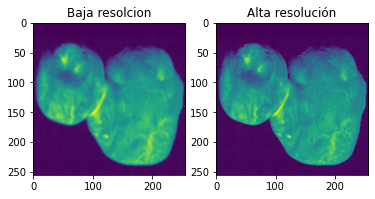

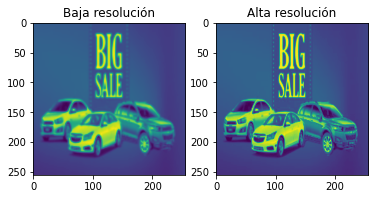

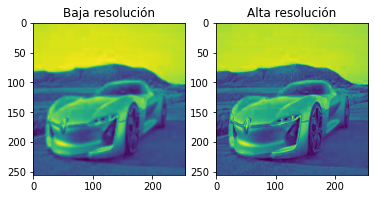

In [14]:
plt.figure(3)
plt.subplot(121)
plt.imshow(np.reshape(img_train[22][0],(256,256))),plt.title('Baja resolcion')
plt.subplot(122),plt.imshow(np.reshape(img_train[22][1],(256,256))), plt.title('Alta resolución')
plt.show()
plt.figure(4)
plt.subplot(121)
plt.imshow(np.reshape(img_val[22][0],(256,256))),plt.title('Baja resolución')
plt.subplot(122),plt.imshow(np.reshape(img_val[22][1],(256,256))), plt.title('Alta resolución')
plt.show()
plt.figure(5)
plt.subplot(121)
plt.imshow(np.reshape(img_test[22][0],(256,256))),plt.title('Baja resolución')
plt.subplot(122),plt.imshow(np.reshape(img_test[22][1],(256,256))), plt.title('Alta resolución')
plt.show()


In [15]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=img_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=img_val, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=img_test, batch_size=batch_size, shuffle=True)

### Modelo

#### Modelo 2

In [16]:
 ################################FORWARD ENCODER####################################################
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        #input 256x256
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0), #252
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=0),#248
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2,padding=0, return_indices = True)) #124
            
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0, return_indices = True) 
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), #120
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0), #116
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2,padding=0, return_indices = True)) #53
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0), #49
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=0), #45
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2,padding=0, return_indices = True)) # 22
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=0), #18
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=0), #14
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2,padding=0, return_indices = True)) # 7
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=0), #3
            nn.Tanh())
            
        self.fc = nn.Linear(in_features=512*4*4, out_features=10)
        
    def forward(self, image):
        #print("image",image.shape)
            
        out0 = self.layer1(image)
        #print("out",out0.shape)
        out1,indice1 = self.MaxPool(out0)
        #print("out1",out1.shape)
            
        out2 = self.layer2(out1)
        #print("out2",out2.shape)
        out3,indice3 = self.MaxPool(out2)
        #print("out3",out3.shape)
            
        out4 = self.layer3(out3)
        #print("out4",out4.shape)
        out5,indice5 = self.MaxPool(out4)
        #print("out5",out5.shape)
            
        out6 = self.layer4(out5)
        #print("out6",out6.shape)
        out7,indice7 = self.MaxPool(out6)
        #print("out7",out7.shape)    
            
        out8 = self.layer5(out7)            
        #print("out8",out8.shape)
        out9 = out8.view(out8.size(0), -1)
        #print("outflatten1",out9.shape)
        z = self.fc(out9)    
        #print("latente enconder",z.shape)
        return z, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6
    
  ################################FORWARD DECODER####################################################
            
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.fc    = nn.Linear(in_features=10,out_features=512*4*4)
        #print("lineal1",self.fc.shape)
        self.layer1Deco = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2,padding=0)
        
        self.layer2Deco = nn.Sequential(
            #nn.MaxUnpool2d(kernel_size=2, stride=2,padding=0), # 13
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=0), #25
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=0), #27
            nn.ReLU())
        
        self.layer3Deco = nn.Sequential(
            #nn.MaxUnpool2d(kernel_size=2, stride=2,padding=0), # 13
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=0), #59
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=1, padding=0), #57
            nn.ReLU())
        
        self.layer4Deco = nn.Sequential(
            #nn.MaxUnpool2d(kernel_size=2, stride=2,padding=0), #6
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0), #124
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=0), #122
            nn.ReLU())
        
        self.layer5Deco = nn.Sequential(
            #nn.MaxUnpool2d(kernel_size=2, stride=2,padding=0), # 13
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=0), #27
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=0), #25
            nn.Tanh())
           
        
    def forward(self, latent, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6):
        #print("latente decoder",latent.shape)
        out = self.fc(latent)
        #print("latente decoder-fc",out.shape)
        out = out.view(out.size(0), 512, 4, 4)
        #print("latente convertida",out.shape)
        out = self.layer1Deco(out)
        #print("layer1Deco",out.shape)
        
        out = self.unpool(out,indice7,output_size=out6.size())
        #print("unpooling",out.shape)
        out = self.layer2Deco(out)
        #print("layer2Deco",out.shape)
        
        out = self.unpool(out,indice5,output_size=out4.size())
        #print("unpooling2",out.shape)
        out = self.layer3Deco(out)
        #print("layer3Deco",out.shape)
        
        out = self.unpool(out,indice3,output_size=out2.size())
        #print("unpooling2",out.shape)
        out = self.layer4Deco(out)
        #print("layer4Deco",out.shape)
        
        out = self.unpool(out,indice1,output_size=out0.size())
        #print("unpooling2",out.shape)
        out = self.layer5Deco(out)
        #print("layer5Deco",out.shape)
        
        return out

In [17]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = Encoder2()
        self.decoder = Decoder2()

    def forward(self, x):
        latent, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6 = self.encoder(x.float())
        x_recon = self.decoder(latent, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6)
        return  x_recon

In [18]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    val_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        
        for image_batch_low,image_batch_high in train_loader:
            image_batch_low = image_batch_low.to(device)
            image_batch_high = image_batch_high.to(device)
            
            
            #print(image_batch.size())
            #print(image_batch)
            
            image_batch_recon = model(image_batch_low)
            # print(image_batch_recon.size())        
           
            
            loss = loss_fn(image_batch_recon, image_batch_high)
            #print("el loss es :",loss)  
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_loss_avg[-1] += loss.item()
            num_batches += 1
          
        train_loss_avg[-1] /= num_batches
        #print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
        
        val_loss_avg.append(0)
        num_batches = 0  
        for image_batch_low, image_batch_high in val_loader:
            image_batch_low = image_batch_low.to(device)
            image_batch_high = image_batch_high.to(device)

            image_batch_recon = model(image_batch_low)

            loss = loss_fn(image_batch_recon, image_batch_high)
            # Calculate loss
            val_loss_avg[-1] +=loss.item()
            num_batches += 1
            
        val_loss_avg[-1] /= num_batches

        print(f'Epoch {epoch+1} Training Loss: {train_loss_avg[-1]} Validation Loss: {val_loss_avg[-1]}')
 
    return train_loss_avg, val_loss_avg

In [19]:
%%time   
learning_rate = 0.001
autoencoder = Autoencoder2().float()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


list_loss_train,list_loss_validation = train(autoencoder,train_loader,20,loss)

Epoch 1 Training Loss: 0.37157134811083475 Validation Loss: 0.4096871390938759
Epoch 2 Training Loss: 0.3330854594707489 Validation Loss: 0.22205468639731407
Epoch 3 Training Loss: 0.33565794229507445 Validation Loss: 0.29322634264826775
Epoch 4 Training Loss: 0.28479602734247844 Validation Loss: 0.21485056728124619
Epoch 5 Training Loss: 0.26243433852990466 Validation Loss: 0.20683176070451736
Epoch 6 Training Loss: 0.21969330509503682 Validation Loss: 0.18619712069630623
Epoch 7 Training Loss: 0.20698545972506205 Validation Loss: 0.2007576823234558
Epoch 8 Training Loss: 0.208849169810613 Validation Loss: 0.19422364979982376
Epoch 9 Training Loss: 0.2149534632762273 Validation Loss: 0.19345560297369957
Epoch 10 Training Loss: 0.2189210295677185 Validation Loss: 0.17777173966169357
Epoch 11 Training Loss: 0.19564509789148968 Validation Loss: 0.16791225969791412
Epoch 12 Training Loss: 0.19296581546465555 Validation Loss: 0.16832676529884338
Epoch 13 Training Loss: 0.1994179864724477 V

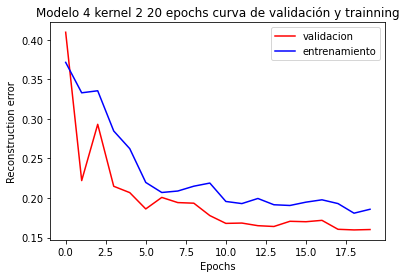

In [20]:
fig = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
#plt.plot(loss_result)
plt.title('Modelo 4 kernel 2 20 epochs curva de validación y trainning')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [21]:
def Show(out, title = ''):
    print(title)
    out = out.permute(1,0,2,3)
    grilla = torchvision.utils.make_grid(out,10,5)
    plt.imshow(transforms.ToPILImage()(grilla), 'jet')
    plt.show()

def Show_Weight(out):
    grilla = torchvision.utils.make_grid(out)
    plt.imshow(transforms.ToPILImage()(grilla), 'jet')
    plt.show()

In [22]:
capacity = 64
latent_dims = 10 
autoencoder.eval()


tensor = torch.zeros(len(test_loader),2)


with torch.no_grad():

    image,label = iter(test_loader).next()
    
    image = image.to(device)
    z, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6 = autoencoder.encoder(image) # Solo decoder para sacar el Z
    #print(z)
    print(z.shape)
    z = z.to('cpu')
    mean = z.mean(dim=0)

    std = (z - mean).pow(2).mean(dim=0).sqrt()

    z1 = torch.randn(16, latent_dims)*std + mean
    z1 = z1.to(device)
    print(z1.shape)
    decodificado = autoencoder.decoder(z1, indice1, indice3, indice5, indice7 ,out0, out2, out4, out6)



    decodificado = decodificado.to('cpu')
    
    fig, ax = plt.subplots(figsize=(256, 256))
    Show_Weight(image[1:5])
    plt.show()
    fig, ax = plt.subplots(figsize=(256, 256))
    Show_Weight(decodificado[1:5])
    plt.show()
    

torch.Size([16, 10])
torch.Size([16, 10])
